## Introduction

This is a notebook to predict the sleep disorder of a person!

## Data preprocessing

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/sleep-health-and-lifestyle-dataset')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'Sleep_health_and_lifestyle_dataset.csv')
modes = df.mode().iloc[0]

One difference with Random Forests however is that we don't generally have to create *dummy variables* like we did for non-numeric columns in the linear models and neural network. Instead, we can just convert those fields to *categorical variables*, which internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values.

In [3]:
df.fillna(modes, inplace=True)
df['Gender'] = pd.Categorical(df.Gender)
df['Sleep Disorder'] = pd.Categorical(df['Sleep Disorder'])
df['Occupation'] = pd.Categorical(df.Occupation)
df['BMI Category'] = pd.Categorical(df['BMI Category'])
df = df.drop(['Person ID', 'Blood Pressure'], axis=1)

df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea


In [4]:
cats=["Gender", "Occupation", "BMI Category"]
conts=['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',"Stress Level"]
dep="Sleep Disorder"

Even although we've made the `cats` columns categorical, they are still shown by Pandas as their original values:

In [5]:
df.Occupation.head()

0       Software Engineer
1                  Doctor
2                  Doctor
3    Sales Representative
4    Sales Representative
Name: Occupation, dtype: category
Categories (11, object): ['Accountant', 'Doctor', 'Engineer', 'Lawyer', ..., 'Salesperson', 'Scientist', 'Software Engineer', 'Teacher']

<AxesSubplot:>

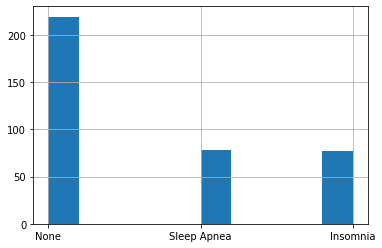

In [6]:
df['Sleep Disorder'].hist()

However behind the scenes they're now stored as integers, with indices that are looked up in the `Categories` list shown in the output above. We can view the stored values by looking in the `cat.codes` attribute:

## Binary splits

### Will pass through every row apply the right integer code on the cats column

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)

trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

### Replace Y variable with integers

In [8]:
trn_df[dep].replace(['None', 'Insomnia', 'Sleep Apnea'],[0,1,2], inplace=True)
val_df[dep].replace(['None', 'Insomnia', 'Sleep Apnea'],[0,1,2], inplace=True)

### Split data frame into 2 parts, with our X variables and Y variable

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [10]:
trn_xs

,Gender,Occupation,BMI Category,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level
222,1,7,3,44,6.3,6,45,7
227,1,7,3,44,6.3,6,45,7
141,1,3,0,38,7.1,8,60,5
17,1,1,0,29,6.0,6,30,8
246,1,7,3,44,6.3,6,45,7
...,...,...,...,...,...,...,...,...
71,1,1,0,33,6.1,6,30,8
106,0,5,3,37,6.1,6,42,6
270,0,5,3,49,6.1,6,90,8
348,0,5,3,57,8.2,9,75,3


In [11]:
trn_y

222    1
227    1
141    0
17     2
246    1
      ..
71     0
106    0
270    2
348    2
102    0
Name: Sleep Disorder, Length: 280, dtype: int64

Now let's find the single best binary split for males...:

## Creating a decision tree

In [12]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=10).fit(trn_xs, trn_y);

* max_leaf_nodes: limits the maximum number of leaf nodes in the decision tree.
* max_depth: imits the maximum depth of the decision tree.

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [13]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

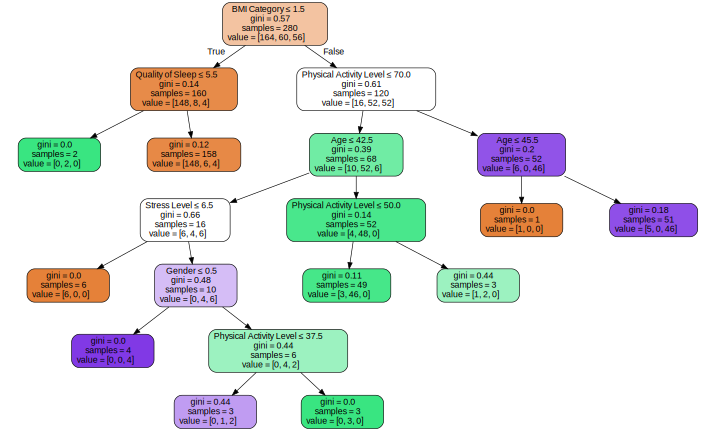

In [14]:
draw_tree(m, trn_xs)

What this calculates is the probability that, if you pick two rows from a group, you'll get the same `Survived` result each time. If the group is all the same, the probability is `1.0`, and `0.0` if they're all different:

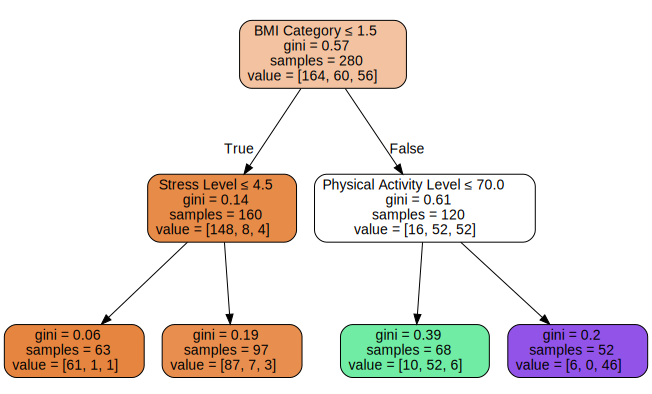

In [15]:
m = DecisionTreeClassifier(min_samples_leaf=50).fit(trn_xs, trn_y)
draw_tree(m, trn_xs)

## The random forest

In [16]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Now we can create as many trees as we want:

In [17]:
trees = [get_tree() for t in range(100)]

Our prediction will be the average of these trees' predictions:

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

accuracy_score(val_y, m.predict(val_xs))

0.8723404255319149

#### As our problem is contains classification, we are going to use the accuracy_score!

This is nearly identical to what `sklearn`'s `RandomForestClassifier` does. The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. Here's how we repeat the above process with a random forest:

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5).fit(trn_xs, trn_y);
accuracy_score(val_y, rf.predict(val_xs))

0.8829787234042553

In [21]:
predict_data = [0, 10, 3, 44 ,6.5, 7, 45, 4]

In [22]:
rf.predict([predict_data])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1])

## Export the model

In [23]:
import joblib

joblib.dump(rf, 'model.pkl')

['model.pkl']

## Gradio Code

In [ ]:
! pip install -q gradio

In [ ]:
import gradio as gr
import pandas as pd

def predict(Gender,Occupation, BMICategory,Age,SleepDuration,QualityofSleep, PhysicalActivityLevel, StressLevel):
    
    Gender = 1 if Gender == 'Male' else 0

    data = [[Gender,Occupation, BMICategory,Age,SleepDuration,QualityofSleep, PhysicalActivityLevel, StressLevel]]

    row_df = pd.DataFrame(data,columns=['Gender','Occupation','BMI Category','Age','Sleep Duration','Quality of Sleep', 'Physical Activity Level','Stress Level'])
    
    result = rf.predict([row_df.iloc[0]])
    
    if result[0] == 0:
         return 'None'
    if result[0] == 1:
         return 'Insomnia'
    if result[0] == 2:
         return 'Sleep Apnea'
    return result[0]

gr.Interface(
    fn=predict,
    title="Predict Stress Level",
    allow_flagging="never",
    inputs=[
        gr.inputs.Radio(["Male", "Female"], label="Gender", default="Female"),
        gr.inputs.Dropdown( list(range(1,11)), label="Occupation", default=10),
        gr.inputs.Radio(list(range(1, 4)), label="BMI Category", default=3),
        gr.inputs.Number(default=44, label="Age"),
        gr.inputs.Number(default=6.5, label="Sleep Duration"),
        gr.inputs.Radio(list(range(1, 9)), label="Quality of Sleep", default=7),
        gr.inputs.Number(default=45, label="Physical Activity Level"),
        gr.inputs.Radio(list(range(1, 8)), label="Stress Level", default=4),
    ],
    outputs="text").launch(inline=False)

## Deploy

Link: https://huggingface.co/spaces/BrunoHenrique00/lesson6